## Image reconstruction in X-ray tomography 

Notebook by Gabriel Ruault and Ethan Trentin

#### 1. X-ray tomography

1. Download the projection matrix H and the image $\overline{x}$ available on the website. Use loadmat from scipy.io in Python to load the arrays, note that H is stored as a sparse matrix.

In [158]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import sparse
from scipy import linalg
import time

In [159]:
path = sys.path[0]+"\\data"
H = sio.loadmat(path+"\\H.mat")
# We transform the sparse matrix into an array
H = H['H']
H.shape

(16200, 8100)

In [160]:
x = sio.loadmat(path+"\\x.mat")
x = x['x']
x = x.flatten()
x

array([0., 0., 0., ..., 0., 0., 0.])

2. Construct $y$, according to model (1) using $\sigma = 1$. 

In [161]:
M = H.shape[0]
N = H.shape[1]

assert M == 90*180
assert N == 90*90

In [162]:
sigma = 1
np.random.seed(42)
w = sigma * np.random.randn(M) 
w

array([ 0.49671415, -0.1382643 ,  0.64768854, ..., -0.53634603,
       -0.55404438,  0.17823974])

In [163]:
y = H @ x + w

assert w.shape[0] == M 
assert y.shape[0] == M
y

array([ 0.49671415, -0.1382643 ,  0.64768842, ..., -0.53690317,
       -0.55404444,  0.17823974])

3. Here $N=90*90$ and $M=90*180$ pixels and measurements. Display a 2D version of $x$ and a 2D version of $y$, also known as sinogram. To do so, in Matlab, use the reshape function ; in Python, use the reshape method with option order="F".

Text(0.5, 1.0, 'Received signal y')

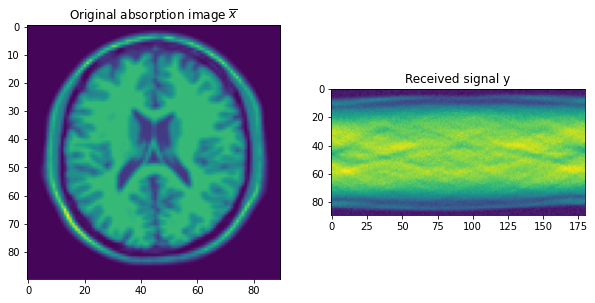

In [164]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].imshow(x.reshape((90,90), order = "F"))
ax[0].set_title("Original absorption image $\overline{x}$")
ax[1].imshow(y.reshape((90,180), order = "F"))
ax[1].set_title("Received signal y")

#### 2. Optimization problem 

An efficient strategy to address the reconstruction problem is to define $x$ as a minimizer of an appropriate cost function $f$. More specifically, we focus on the following penalized least-squares criterion : 

$$\forall x \in \mathbb{R}^N, f(x) = \frac{1}{2} \Vert Hx-y \Vert^2 + \lambda r(x)$$

where $r$ is a regularization function incorporating a priori assumptions to guarantee the robutness of the solution with respect to noise. In order to promote images formed by smooth regions separated by sharp edges, we set : 

$$\forall x \in \mathbb{R}^N, r(x) = \sum_{n=1}^{2N} \psi([Gx]^{(n)})$$

where $G \in \mathbb{R}^{2NxN}$ is a sparse matrix such that $Gx \in \mathbb{R}^{2N}$ is the concatenation of the horizontal and vertical gradients of the image and $\psi$ is a potential function defined as :

$$\forall u \in \mathbb{R}, \psi(u) = \sqrt{1+\frac{u^2}{\delta^2}}$$

with some parameter $\delta>0$ aiming at guaranteeing the differentiability of $r$. In the following, we will set $(\lambda, \delta) = (0.13,0.02)$. 

1. Download the gradient operator $G$ available in the website. 

In [165]:
G = sio.loadmat(path+"\\G.mat")
G = G["G"]
G.shape

(16200, 8100)

2. Give the expression of the gradient $\nabla f$ at some point $x \in \mathbb{R}^N$. Create a function which gives as an output the gradient of $f$ at some input vector $x$. 


**Question 2**:

We write $G = (C_1, ...., C_N)$ with the $C_i$ the columns of G.

We find that $\partial_{x_i}r(x) = \sum_{n = 1}^N\psi'([Gx]^{(n)})G_{n,i} = C_i^T\psi_{vec}'(Gx) $.

Thus we see that $ \nabla r(x) = G^T\psi_{vec}'(Gx)$

With $ \psi_{vec}'(Gx) = (\psi'([Gx]^{(n)}))_{n = 1,...N}$

and  $\psi'(u) = \frac{u}{\delta^2 \psi(u)}$



In [166]:
eps = 1e-8
def psi(u):
  return np.sqrt(1+ u**2/delta**2)

# Let's code this expression :
def psi_gradient(u):
    return u/(delta**2*psi(u))

def f_gradient(x):
    gradient = H.T@(H@x-y) + Lambda*G.T@psi_gradient(G@x)
    return gradient

3. Show that a Lipschitz constant of $\nabla f$ is : 
$$L=\Vert H \Vert^2 + \frac{\lambda}{\delta^2}\Vert G \Vert^2$$

Calculate it for the $(\lambda, \delta)$ values given above. Note that, in Matlab, one can use normest to evaluate the norm of a sparse matrix ; in Python, the function scipy.parse.linalg.svds gives the singular values of a sparse matrix, the maximal singular value being the norm of the matrix. 

**Question 3**: 

$\nabla r(x) - \nabla r(x') = G^T(\psi_{vec}'(Gx) - \psi_{vec}'(Gx'))$
$\| \nabla r(x) - \nabla r(x')\|_2 = \|G^T(\psi_{vec}'(Gx) - \psi_{vec}'(Gx'))\|_2 \leq \|G^T\|_2 \|\psi_{vec}'(Gx) - \psi_{vec}'(Gx')\| $ 

by definition of  the subordinate l2 matrix norm.

At each component of $\psi_{vec}'(Gx) - \psi_{vec}'(Gx')$, we use the mean value inequality, $|\psi'(u) - \psi'(v)| \leq \sup_{w \in [u,v]} \psi''(w)|u-v|$.

We find that $\psi''(u) = \frac{1 - \frac{u^2}{\delta^2 \left(1 + \frac{u^2}{\delta^2}\right)}}{\delta^2 \sqrt{1 + \frac{u^2}{\delta^2}}}$ 

One sees that $\frac{u^2}{\delta^2 \left(1 + \frac{u^2}{\delta^2}\right)} \leq 1$ thus $\psi''(u) \geq 0$ and $\psi''(u) \leq \frac{1}{\delta^2 \sqrt{1 + \frac{u^2}{\delta^2}}} \leq \frac{1}{\delta^2}$ 

Thus combining all the components together, one gets: 

$\|\psi_{vec}'(Gx) - \psi_{vec}'(Gx')\|_2 \leq \frac{1}{\delta^2}\|Gx-Gx'\|_2 \leq \frac{1}{\delta^2}\|G\|_2\|x-x'\|$

Combining everything we get: $\| \nabla r(x) - \nabla r(x-x')\|_2 \leq \frac{1}{\delta^2}\|G\|_2^2\|x-x'\|_2$

It is easy to see that $\|H^T(Hx-y) - H^T(Hx'-y)\|\leq \|H^TH\|_2\|x-x'\|_2 $

We now only have to recall that the l2 subordinate matrix norm of a symmetric matrix is equal to its spectral norm hence  $ \lambda_{max}(H^TH) =(\lambda_{max}(H))^2 = \|H^TH\|_2$.

Since the singular values of $H$ are defined by $ \text{sv}_i(H) = \sqrt{\lambda_i(H^TH)}$, with the convention of $\|A\| = \text{sv}_{max}(A),$, we can thus write: 

$ L = \|H\|^2 + \frac{\lambda}{\delta^2}\|G\|^2$

In [167]:
Lambda = 0.13
delta = 0.02
H_norm = np.max(sparse.linalg.svds(H, return_singular_vectors=False))
G_norm = np.max(sparse.linalg.svds(G, return_singular_vectors=False))
L = H_norm**2+(Lambda/(delta)**2)*G_norm**2
L

18092.77327686477

#### 3. Optimization algorithms

3.1 Gradient descent algorithm 

1. Create $x_0 \in \mathbb{R}^N$ a vector with all entries equal to 0. This will be our initialization for all tested algorithms. 

In [168]:
x0 = np.zeros(x.shape)
x0

array([0., 0., 0., ..., 0., 0., 0.])

2. Implement a gradient descent algorithm to minimize $f$.

In [169]:
x_tol = 1e-4

In [170]:
def f(x):
    return 1/2*np.linalg.norm(H@x-y)**2+Lambda*np.sum(np.sqrt(1+(G@x)**2/delta**2))

In [171]:
def GradientDescent(f, f_gradient, x_tol):
    x_curr = x0.copy()
    f_liste = []
    iterations = []
    t0 = time.time()
    counter = 0

    while np.linalg.norm(f_gradient(x_curr))>np.sqrt(N)*x_tol: # Putting a condition on the norm of the gradient is equivalent to putting a condition on the norm of the difference between two consecutive x.
        # It is stronger than the condition on one of the components of the difference of two cvonsecutive x. 
        x_next = x_curr - 1/L*f_gradient(x_curr)
        x_curr = x_next
        if counter % 100 == 0:
            f_liste.append(f(x_curr))
            iterations.append(time.time()-t0)
            print("iter {}:  \tf(x) = {:.6f}\t||∇f(x)|| = {:.6f}".format(counter + 1, f(x_curr), np.linalg.norm(f_gradient(x_curr))))
        counter += 1
    print("stopping criterion reached, stopping now")
    final_time = time.time()-t0
    print("Time taken to converge :", final_time, "seconds")
    return x_curr, f_liste, iterations, final_time

In [172]:
x_hat_GD, f_liste_GD, iterations_GD, final_time_GD = GradientDescent(f, f_gradient, x_tol)

iter 1:  	f(x) = 415133.843046	||∇f(x)|| = 75050.220771
iter 101:  	f(x) = 13509.039421	||∇f(x)|| = 501.356757
iter 201:  	f(x) = 13041.000347	||∇f(x)|| = 151.770416
iter 301:  	f(x) = 12973.739216	||∇f(x)|| = 77.581348
iter 401:  	f(x) = 12953.137709	||∇f(x)|| = 46.758230
iter 501:  	f(x) = 12945.060140	||∇f(x)|| = 30.504121
iter 601:  	f(x) = 12941.499487	||∇f(x)|| = 20.699351
iter 701:  	f(x) = 12939.797129	||∇f(x)|| = 14.658479
iter 801:  	f(x) = 12938.917449	||∇f(x)|| = 10.704451
iter 901:  	f(x) = 12938.439992	||∇f(x)|| = 7.962296
iter 1001:  	f(x) = 12938.172138	||∇f(x)|| = 6.014023
iter 1101:  	f(x) = 12938.017229	||∇f(x)|| = 4.610837
iter 1201:  	f(x) = 12937.925026	||∇f(x)|| = 3.582713
iter 1301:  	f(x) = 12937.868765	||∇f(x)|| = 2.815251
iter 1401:  	f(x) = 12937.833717	||∇f(x)|| = 2.232957
iter 1501:  	f(x) = 12937.811502	||∇f(x)|| = 1.785330
iter 1601:  	f(x) = 12937.797205	||∇f(x)|| = 1.437629
iter 1701:  	f(x) = 12937.787878	||∇f(x)|| = 1.165265
iter 1801:  	f(x) = 12937

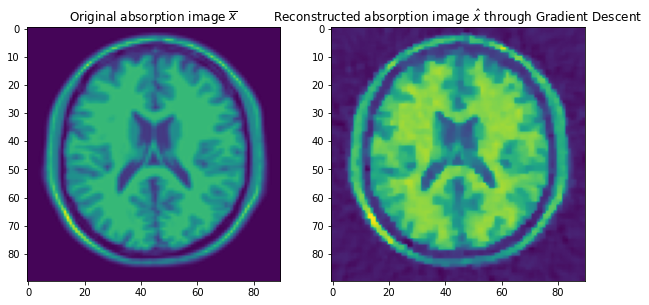

In [173]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].imshow(x.reshape((90,90), order = "F"))
ax[0].set_title("Original absorption image $\overline{x}$")
ax[1].imshow(x_hat_GD.reshape((90,90), order = "F"))
ax[1].set_title("Reconstructed absorption image $\hat{x}$ through Gradient Descent") 
plt.show()

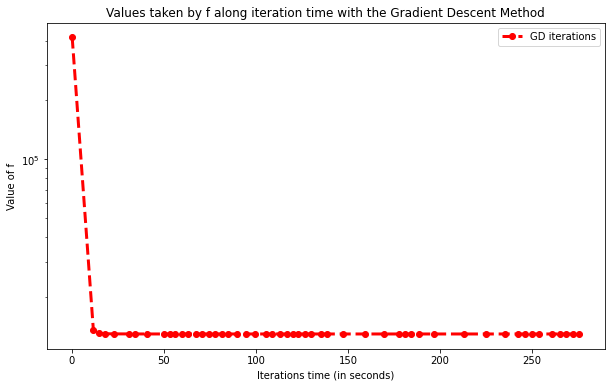

In [174]:
plt.figure(figsize=(10, 6))
plt.plot(iterations_GD, f_liste_GD, color ="r", linestyle="--", marker="o", linewidth=3,  label= "GD iterations")
plt.xlabel("Iterations time (in seconds)")
plt.ylabel("Value of f")
plt.yscale("log")
plt.title("Values taken by f along iteration time with the Gradient Descent Method")
plt.legend()
plt.show()

3.2 MM quadratic algorithm

1. Construct, $\forall x \in \mathbb{R}^N$ , a quadratic majorant function of $f$ at $x$. Create a function which gives, as an output, the curvature $A(x)$ of the majorant function at an input vector $x$.
Hint : in Matlab, use spdiags to create a sparse diagonal matrix ; in Python,
use scipy.sparse.diags(d[:,0]).tocsc() to create a sparse matrix from a
diagonal vector $d \in \mathbb{R}^{n×1}$ using the compressed sparse column format. In addition, in Python, use the class LinearOperator from scipy.sparse.linalg to create the curvature operator.

**Question 1**:

Given $f$ is $L$-Lispschitz differentiable, one could think of using $A(x) = \frac{L}{2}/I_n$  using the descent lemma. **This would however be exactly equivalent to gradient descent.**

As the Lipschitz constant was computed as a maximum over $\mathbb{R}$, the corresponding curvature is likely going to be very large and will give us very peaky majorizations with minima very close to each $x_n$. This slows the convergence. On the other hand , it is easy and fast to compute.

In the rest of the project, we will try to strike a balance between  having useful majorants and fast computations.

We hence look for a majorant which better espouses the local curvature (being a function of $x$ will help) than $\frac{L}{2}/I_n$. 


$\psi$ defined by $\psi(u) = \sqrt{1+\frac{u^2}{\delta^2}}$ verifies the hyptheses in Slide 13 of the lecture notes on MM methods.
* $\psi$ is even and differentiable
* $ \psi'(u) = \frac{u}{\delta^2\psi(u)} \geq 0 $ for $u \in \mathbb{R}$
* $\psi(\sqrt{u}) =\sqrt{1+\frac{u}{\delta^2}} $is obviously concave on $\mathbb{R}^+$
* $ u \to \frac{\psi'(u)}{u} = \frac{1}{\delta^2\psi(u)}$ tends to $\frac{1}{\delta^2} \in \mathbb{R} $ as u tends to 0.

Thus each term in $r(x)$ can be bounded by:  $ \psi([Gx]^{(n)}) \leq \psi([Gy]^{(n)}) + \psi'([Gy]^{(n)}) ([Gx]^{(n)}-[Gy]^{(n)}) + \frac{1}{\delta^2\psi([Gx]^{(n)})}([Gx]^{(n)}- [Gy]^{(n)})^2$

Since we only modified the quadratic term in r, when adding all the terms together,  one gets:

$ r(x) \leq \psi(y) + (x-y)^T\nabla r(y) + (x-y)^TG^T\text{diag}\left(\frac{1}{\psi([Gy]^{(1)})}...\frac{1}{\psi([Gy]^{(2N)})}\right)G(x-y)$

And by adding the hessian from  the quadratic term one gets

$A(x) = H^TH + \frac{\lambda}{\delta^2}G^T\text{diag}\left(\frac{1}{\psi([Gx]^{(1)})}...\frac{1}{\psi([Gx]^{(2N)})}\right)G$


In [175]:
def curvature(x):
    vector = 1/(delta**2*np.sqrt(1+(G@x)**2/delta**2))
    Diag = sparse.diags(vector).tocsc()
    return lambda z : H.T@(H@(z)) + Lambda * G.T@(Diag@(G@(z)))

2. Deduce a MM quadratic algorithm to minimize $f$. Implement it.
Hint : in Matlab use pcg to invert the majorant matrix at each iteration ; in Python, use bicg from scipy.sparse.linalg.

We will code the MM algorithm with the following recursive formula : 

$$(\forall n \in \mathbb{N}), x_{n+1} = x_n - \theta_n A(x_n)^{-1} \nabla f(x_n)$$

where for all $n \in \mathbb{N}$, $\theta_n \in ]0,2[$. We take for all $n \in \mathbb{N}, \theta_n = 1$.

In [176]:
def Maj_Min_Quadratic(f, f_gradient, x_tol):
    x_curr = x0.copy()
    f_liste = []
    iterations = []
    t0 = time.time()
    counter = 0
    while np.linalg.norm(f_gradient(x_curr))>np.sqrt(N)*x_tol:
        mat = curvature(x_curr)
        A_matrix = sparse.linalg.LinearOperator((N, N), matvec=mat, rmatvec=mat)
        x_curr -= sparse.linalg.cg(A_matrix, f_gradient(x_curr))[0] # Use of cg instead of bicg as the matrix is symmetric
        if counter % 5 == 0:
            f_liste.append(f(x_curr))
            iterations.append(time.time()-t0)
            print("iter {}:  \tf(x) = {:.6f}\t||∇f(x)|| = {:.6f}".format(counter + 1, f(x_curr), np.linalg.norm(f_gradient(x_curr))))
        counter += 1
    print("stopping criterion reached, stopping now")
    final_time = time.time()-t0
    print("Time taken to converge :", final_time, "seconds")
    return x_curr, f_liste, iterations, final_time

In [177]:
x_hat_MM, f_liste_MM, iterations_MM, final_time_MM = Maj_Min_Quadratic(f, f_gradient, x_tol)

iter 1:  	f(x) = 15573.443107	||∇f(x)|| = 1242.514636
iter 6:  	f(x) = 12949.567369	||∇f(x)|| = 49.205401
iter 11:  	f(x) = 12938.735572	||∇f(x)|| = 12.309702
iter 16:  	f(x) = 12937.904785	||∇f(x)|| = 4.177832
iter 21:  	f(x) = 12937.794354	||∇f(x)|| = 1.669452
iter 26:  	f(x) = 12937.774332	||∇f(x)|| = 0.755317
iter 31:  	f(x) = 12937.769834	||∇f(x)|| = 0.372275
iter 36:  	f(x) = 12937.768662	||∇f(x)|| = 0.194843
iter 41:  	f(x) = 12937.768322	||∇f(x)|| = 0.106417
iter 46:  	f(x) = 12937.768216	||∇f(x)|| = 0.059886
iter 51:  	f(x) = 12937.768182	||∇f(x)|| = 0.034412
iter 56:  	f(x) = 12937.768170	||∇f(x)|| = 0.020070
iter 61:  	f(x) = 12937.768166	||∇f(x)|| = 0.011832
stopping criterion reached, stopping now
Time taken to converge : 64.40642952919006 seconds


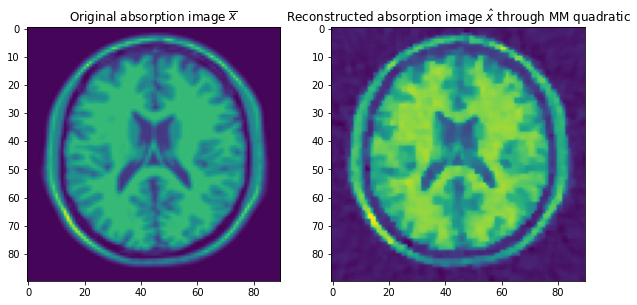

In [178]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].imshow(x.reshape((90,90), order = "F"))
ax[0].set_title("Original absorption image $\overline{x}$")
ax[1].imshow(x_hat_MM.reshape((90,90), order = "F"))
ax[1].set_title("Reconstructed absorption image $\hat{x}$ through MM quadratic") 
plt.show()

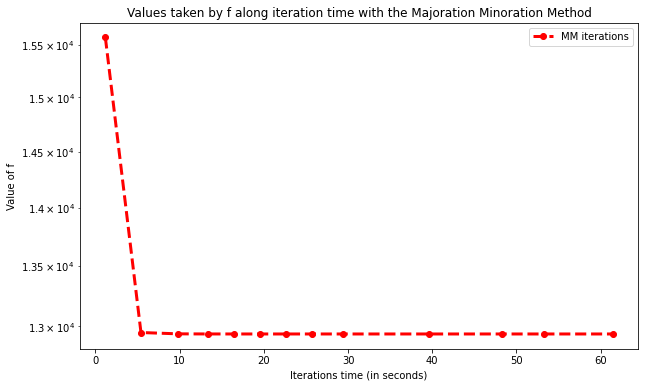

In [179]:
plt.figure(figsize=(10, 6))
plt.plot(iterations_MM, f_liste_MM, color ="r", linestyle="--", marker="o", linewidth=3,  label= "MM iterations")
plt.xlabel("Iterations time (in seconds)")
plt.ylabel("Value of f")
plt.yscale("log")
plt.title("Values taken by f along iteration time with the Majoration Minoration Method")
plt.legend()
plt.show()

3.3 3MG algorithm 

The MM quadratic algorithm can be accelerated by using a subspace strategy. Here, we will focus on the so-called 3MG (MM Memory Gradient) approach which consists in defining the iterate $x_{k+1}$ as the minimizer of the quadratic majorant
function at $x_k$ within a subspace spanned by the following directions : $$(\forall k \in \mathbb{N}), D_k = [−\nabla f(x_k) | x_k − x_{k−1}]$$
(with the convention $D_0 = −\nabla f(x_0)$). Thus, an iterate of 3MG reads : 
$$(\forall k \in \mathbb{N}), x_{k+1} = x_k + D_ku_k$$
with $(\forall k \in \mathbb{N}), u_k = −(D^T_k A(x_k)D_k)^†(D^T_k \nabla f(x_k))$
where $A(x_k) \in \mathbb{R}^{N×N}$ is the curvature of the majorant matrix at $x_k$ and † denotes
the pseudo-inverse operation.

1. Implement the 3MG algorithm.
Hint : use pinv in Matlab and scipy.linalg.pinv in Python to compute the
pseudo-inverse. Given the size of the matrices, mind the order of matrix multiplications, e.g. when computing $D^T_k H^THD_k$, do not compute $D^T_k(H^TH)D_k$ but $(HD_k)^T(HD_k)$.

In [180]:
def directions_subspace(x_curr, x_previous=None, beginning = False):
    if beginning:
        return -f_gradient(x_curr).reshape(-1,1)
    else:
        return np.column_stack((-f_gradient(x_curr).reshape(-1, 1), (x_curr - x_previous).reshape(-1, 1)))

In [187]:
def u_vector(x_curr, D_curr, beginning=False):
    D = D_curr
    vector = 1/(delta**2*np.sqrt(1+(G@x_curr)**2/delta**2))
    Diag = sparse.diags(vector).tocsc()
    first_term = H@D
    second_term = G@D
    comb = first_term.T@first_term + Lambda * second_term.T@Diag@second_term
    if beginning:
        third_term = D.T@f_gradient(x_curr).reshape(-1,1)
    else:
        third_term = D.T@f_gradient(x_curr)
    u = -linalg.pinv(comb)@third_term
    return u

In [188]:
def Maj_Min_Memory_Gradient(f, f_gradient, x_tol):
    x_curr = x0.copy()
    f_liste = []
    iterations = []
    t0 = time.time()
    counter = 0
    D_0 = directions_subspace(x_curr, beginning = True)
    u_0 = u_vector(x_curr, D_0, beginning = True)
    x_next=x_curr+D_0@u_0.flatten()

    while np.linalg.norm(f_gradient(x_next))>np.sqrt(N)*x_tol:
        x_previous = x_curr
        x_curr = x_next
        D_curr = directions_subspace(x_curr, x_previous)
        u_curr = u_vector(x_curr, D_curr)
        x_next = x_curr + D_curr@u_curr.flatten()
        if counter % 20 == 0:
            f_liste.append(f(x_curr))
            iterations.append(time.time()-t0)
            print("iter {}:  \tf(x) = {:.6f}\t||∇f(x)|| = {:.6f}".format(counter + 1, f(x_next), np.linalg.norm(f_gradient(x_next))))
        counter += 1
    print("stopping criterion reached, stopping now")
    final_time = time.time()-t0
    print("Time taken to converge :", final_time, "seconds")
    return x_curr, f_liste, iterations, final_time

In [189]:
x_hat_MMM, f_liste_MMM, iterations_MMM, final_time_MMM = Maj_Min_Memory_Gradient(f, f_gradient, x_tol)

iter 1:  	f(x) = 55881.418425	||∇f(x)|| = 11564.249452
iter 21:  	f(x) = 12961.598839	||∇f(x)|| = 146.626549
iter 41:  	f(x) = 12938.503317	||∇f(x)|| = 20.004945
iter 61:  	f(x) = 12937.798736	||∇f(x)|| = 4.056472
iter 81:  	f(x) = 12937.770686	||∇f(x)|| = 0.872195
iter 101:  	f(x) = 12937.768357	||∇f(x)|| = 0.247325
iter 121:  	f(x) = 12937.768175	||∇f(x)|| = 0.062056
iter 141:  	f(x) = 12937.768164	||∇f(x)|| = 0.013288
stopping criterion reached, stopping now
Time taken to converge : 50.04037165641785 seconds


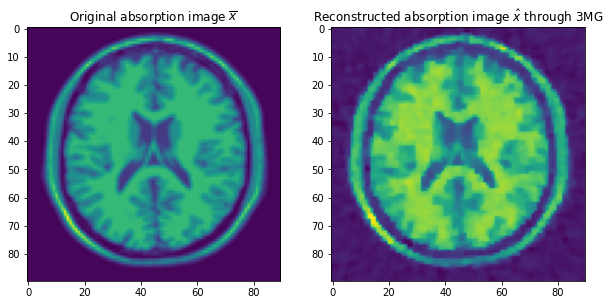

In [190]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].imshow(x.reshape((90,90), order = "F"))
ax[0].set_title("Original absorption image $\overline{x}$")
ax[1].imshow(x_hat_MMM.reshape((90,90), order = "F"))
ax[1].set_title("Reconstructed absorption image $\hat{x}$ through 3MG") 
plt.show()

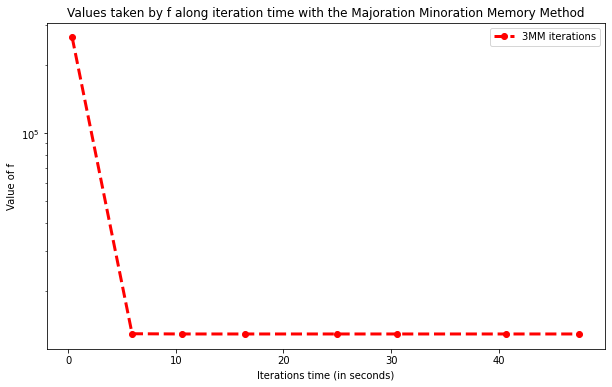

In [191]:
plt.figure(figsize=(10, 6))
plt.plot(iterations_MMM, f_liste_MMM, color ="r", linestyle="--", marker="o", linewidth=3,  label= "3MM iterations")
plt.xlabel("Iterations time (in seconds)")
plt.ylabel("Value of f")
plt.yscale("log")
plt.title("Values taken by f along iteration time with the Majoration Minoration Memory Method")
plt.legend()
plt.show()

3.4 Block-coordinate MM quadratic algorithm

Another acceleration strategy consists in applying a block alternation technique. The vector x is divided into $J \ge 1$ blocks, with size $1 \le N_j \le N$. At each iteration $k \in \mathbb{N}$, a block index $j \subset \{1, . . . , J\}$ is chosen, and the corresponding components
of x, denoted $x^{(j)}$, are updated, according to a MM quadratic rule. Here, we will assume that the blocks are selected in a cyclic manner, that is,
$(\forall k \in  \mathbb{N}), j = mod(k − 1, J) + 1$.
For a given block index j, the corresponding pixel indexes are updated in the image : $n \in J_j = \{(j − 1)N_j + 1, . . . , jN_j \}$. 

1. Create a function which gives, as an output, matrix $A_j(x) \in \mathbb{R}^{N_jxN_j}$ containing only the lines and rows of $A(x)$ with indexes $\mathbb{J}_j$.

In [192]:
def A_block_coordinate(x, j, Nj):
    block_H = H[:, (j - 1) * Nj : j * Nj]
    block_G = G[:, (j - 1) * Nj : j * Nj]
    d = 1 / (delta**2 * np.sqrt(1 + G.dot(x) ** 2 / delta ** 2)) 
    D_G = sparse.diags(d).tocsc()
    
    return block_H.T.dot(block_H) + Lambda * block_G.T.dot(D_G.dot(block_G))

2. Deduce an implementation of a block coordinate MM quadratic algorithm
for minimizing $f$. Test it for $N_j = \frac{N}{K}$ with $K \in \{1, 2, 3, 5, 6, 9 \}$.

**3.4 Question 2**:

* In the MM algorithm, the formula for the iterations is obtained by computing the gradient of the quadratic majorant and setting it to 0.

* We thus only consider the components of the gradient which correspond to the parameters $x$ within the block considered.

* Setting these components of the gradient equal to zero is equivalent to extracting the corresponding lines in the update for a general A.

* This is essentially due to the fact that taking the gradient of something quadratic yields something affine.

This justifies the update rule for block MM.

In [193]:
def Block_Maj_Min_Quadratic(f, f_gradient, x_tol, K):
    x_curr = x0.copy()
    f_liste = []
    iterations = []
    t0 = time.time()
    counter = 0    
    while np.linalg.norm(f_gradient(x_curr))>np.sqrt(N)*x_tol:
        j = (counter % K) + 1
        N_j = N//K
        bound_down, bound_up = (j-1)*N_j, j*N_j
        A_matrix_j = A_block_coordinate(x_curr, j, N_j) # We tried with the conversion into a LinearOperator but it was rendering a mismatch dimension error. 
        x_curr[bound_down : bound_up] = x_curr[bound_down : bound_up] - sparse.linalg.cg(A_matrix_j, f_gradient(x_curr)[bound_down:bound_up])[0]
        if counter % 10 == 0:
            f_liste.append(f(x_curr))
            iterations.append(time.time()-t0)
            print("iter {}:  \tf(x) = {:.6f}\t||∇f(x)|| = {:.6f}".format(counter + 1, f(x_curr), np.linalg.norm(f_gradient(x_curr))))
        counter += 1
    print("stopping criterion reached, stopping now")
    final_time = time.time()-t0
    print("Time taken to converge :", final_time, "seconds")
    return x_curr, f_liste, iterations, final_time        

The algorithm BMM for K=1 is the MM algorithm so we are going to test it only for the rest of K values.

In [195]:
K_values = [2, 3, 5, 6, 9]
x_hat_BMM = []
f_liste_BMM = []
iterations_BMM = []
final_time_BMM = []
for K in K_values:
    print('K =', K)
    x_hat_k, f_liste_k, iterations_k, final_time_k = Block_Maj_Min_Quadratic(f, f_gradient, x_tol, K)
    x_hat_BMM.append(x_hat_k)
    f_liste_BMM.append(f_liste_k)
    iterations_BMM.append(iterations_k)
    final_time_BMM.append(final_time_k)

K = 2
iter 1:  	f(x) = 1660033.940028	||∇f(x)|| = 153368.120378
iter 11:  	f(x) = 19583.511216	||∇f(x)|| = 3855.343069
iter 21:  	f(x) = 13160.239846	||∇f(x)|| = 770.141388
iter 31:  	f(x) = 12941.799151	||∇f(x)|| = 92.472430
iter 41:  	f(x) = 12937.950622	||∇f(x)|| = 9.795267
iter 51:  	f(x) = 12937.789861	||∇f(x)|| = 2.113893
iter 61:  	f(x) = 12937.772254	||∇f(x)|| = 0.738615
iter 71:  	f(x) = 12937.769162	||∇f(x)|| = 0.326070
iter 81:  	f(x) = 12937.768445	||∇f(x)|| = 0.161062
iter 91:  	f(x) = 12937.768250	||∇f(x)|| = 0.084771
iter 101:  	f(x) = 12937.768192	||∇f(x)|| = 0.046477
iter 111:  	f(x) = 12937.768173	||∇f(x)|| = 0.026196
iter 121:  	f(x) = 12937.768167	||∇f(x)|| = 0.015054
iter 131:  	f(x) = 12937.768165	||∇f(x)|| = 0.008773
stopping criterion reached, stopping now
Time taken to converge : 412.83552289009094 seconds
K = 3
iter 1:  	f(x) = 3106956.080154	||∇f(x)|| = 236051.571627
iter 11:  	f(x) = 38412.577034	||∇f(x)|| = 7014.681858
iter 21:  	f(x) = 15504.601840	||∇f(x)

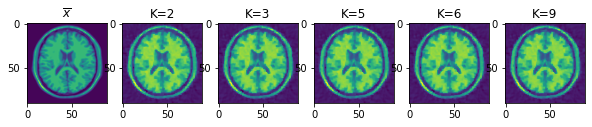

In [196]:
fig, ax = plt.subplots(1,len(K_values)+1, figsize = (10,6))
ax[0].imshow(x.reshape((90,90), order = "F"))
ax[0].set_title("$\overline{x}$")
for i in range(1, len(K_values)+1):
    ax[i].imshow(x_hat_BMM[i-1].reshape((90,90), order = "F"))
    ax[i].set_title(f"K={K_values[i-1]}")
plt.show()

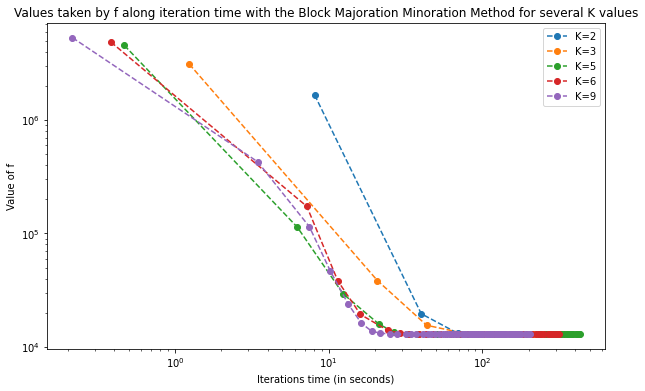

In [198]:
plt.figure(figsize=(10, 6))
colors = plt.get_cmap("tab10").colors
for i in range(len(K_values)):
    plt.plot(iterations_BMM[i], f_liste_BMM[i], color=colors[i%len(colors)], linestyle="--", marker="o", label=f"K={K_values[i]}")
plt.xlabel("Iterations time (in seconds)")
plt.ylabel("Value of f")
plt.xscale("log")
plt.yscale("log")
plt.title("Values taken by f along iteration time with the Block Majoration Minoration Method for several K values")
plt.legend()
plt.show()

The more K increases, the more steps it requires for convergence to happen but the less time it takes. Therefore, the methods are less precise at each iteration when K increases but they are easier to compute. K=5 doesn't obey to that rule but convergence time seems also to depend on how the computer's memory and cores are allocated to tasks. 

3.5 Parallel MM quadratic algorithm

In order to benefit from the multicore structure of modern computer architecture, a parallel form of the MM quadratic algorithm is desirable. However, the quadratic majorizing function defined in Section 3.2 is not separable with respect to the
entries of vector x so that its minimization cannot be performed efficiently in a parallel manner. Here, we propose an alternative construction, that possesses a better potential for parallelization.

1. For every $x \in \mathbb{R}^N$, let $B(x) \in \mathbb{R}^{N\text{x}N}$ be a diagonal matrix with elements $$(\forall i \in \{1,...,N \}), b^{(i)}(x) = \mathcal{H}^T\mathbb{1} + \lambda \mathcal{G}^T (\frac{\dot{\phi}(Gx)}{Gx})$$
with $\mathcal{H} \in \mathbb{R}^M, \mathcal{G} \in \mathbb{R}^{2N}$, and $$\mathcal{H}^{(m)} = \vert H^{(m,i)} \vert \sum_{p=1}^N \vert H^{(m,p)} \vert$$
$$\mathcal{G}^{(n)} = \vert G^{(n,i)} \vert \sum_{p=1}^N \vert G^{(n,p)} \vert$$
Prove that, for every $x \in \mathbb{R}^N$, $A(x) \preceq B(x)$ where $A(.)$ was defined in Section 3.2. 

Hint : use Jensen’s inequality.

Recall $A(x) = H^TH + \lambda G^T\text{diag}\left(\frac{\psi'(|[Gx]^{(n)}|)}{|[Gx]^{(n)}|}\right)G$

One sees $B$ is constructed symmetrically with one term related to  quadratic the $H^TH$ term and the other to the regularisation term in $A$.

**Part I**:

We thus start by proving that the left hand side of $H^TH \preceq \text{diag (}\mathcal{H}^T1)$.

Let $x \in \mathbb{R}^N$
$ xH^THx =  \|Hx\|^2 = \sum_{i=1}^N \left( \sum_{n=1}^N H_{m,n}x_n \right )^2$.

Looking at each individual term in the sum one sees for $ m \in [1,M]$:
$\left( \sum_{n=1}^N H_{m,n}x_n \right )^2 \leq \left( \sum_{n=1}^N |H_{m,n}|x_n \right )^2 =  \left( \sum_{n=1}^N \frac{|H_{m,n}|}{C_m} C_m x_n \right )^2$ with $C_m = \sum_{n=1}^N |H_{m,n}|$

Thus  $\left( \sum_{n=1}^N H_{m,n}x_n \right )^2 \leq \left( \sum_{n=1}^N \frac{|H_{m,n}|}{C_m} x_m \right )^2 C_m^2 = \left( \sum_{n=1}^N \lambda_n x_n \right )^2 C_m^2 $ with $\sum\lambda_n = 1$

Using Jensen's inequality, one gets

$\left( \sum_{n=1}^N H_{m,n}x_m \right )^2 \underset{Jensen}\leq  \sum_{n=1}^N |H_{m,n}|C_m x_n^2 = \sum_{n=1}^N |H_{m,n}|\sum_{p=1}^N |H_{m,p}| x_n^2 = \sum_{n=1}^N \mathcal{H}^{(m)} x_n^2$

By the definition of $B$ one sees:  $x^T\text{diag (}\mathcal{H}^T1)x = \sum_{n=1}^N \sum_{m=1}^M \mathcal{H}^{(m)} x_n^2 = \sum_{m=1}^M \sum_{n=1}^N \mathcal{H}^{(m)} x_n^2$

Thus by adding all the terms of $\|Hx\|^2$ together, one gets that

 $ x^TH^THx = \sum_{i=1}^N \left( \sum_{n=1}^N H_{m,n}x_n \right )^2 \leq \sum_{m=1}^M \sum_{n=1}^N \mathcal{H}^{(m)} x_n^2 = x^T\text{diag (}\mathcal{H}^T1)x$

**Part II**:

 We write $ D^{1/2} = \text{diag}\left(\sqrt{\frac{\psi'(|[Gx]^{(n)}|)}{|[Gx]^{(n)}|}}\right)$ and writing $\tilde{G} = D^{1/2}G$ , we get:

 $x^TG^T\text{diag}\left(\frac{\psi'(|[Gx]^{(n)}|)}{|[Gx]^{(n)}|}\right)Gx =  x^T\tilde{G}^T\tilde{G}x = \sum_{m=1}^{2N} \left(\sum_{n=1}^N \tilde{G}_{m,n}x_n \right)^2$ and with the same proof as above we get that for $m \in [1,2N]$:

$\left(\sum_{n=1}^N \tilde{G}_{m,n}x_n \right)^2 \leq \sum_{n=1}^N |\tilde{G}_{m,n}|\tilde{C}_m x_n^2 $ with $\tilde{C}_m = \sum_{p=1}^N |\tilde{G}_{m,p}|$

By definition, one has that $x^T \text{diag} \left( \mathcal{G}^\top \left( \frac{\dot{\psi}(\mathbf{Gx})}{\mathbf{Gx}} \right) \right)x = \sum_{n = 1}^N x_n^2 \sum_{m = 1}^{2N}\mathcal{G}_n^{(m)} D_m = \sum_{n = 1}^N x_n^2 \sum_{m = 1}^{2N} |{G}_{m,n}| \sum_{p=1}^N |{G}_{m,p}|    D_m $

Since $|\tilde{G}_{m,n}| = |G_{m,n}|D_m^{\frac{1}{2}} $, we get:

$x^T \text{diag} \left( \mathcal{G}^\top \left( \frac{\dot{\psi}(\mathbf{Gx})}{\mathbf{Gx}} \right) \right)x = \sum_{n = 1}^N x_n^2 \sum_{m = 1}^{2N} D_m^{-\frac{1}{2}}|\tilde{G}_{m,n}| \sum_{p=1}^N D_m^{-\frac{1}{2}}|\tilde{G}_{m,p}|D_m = \sum_{n=1}^N |\tilde{G}_{m,n}|\tilde{C}_m x_n^2$ by cancelling out the terms in $D$

We get back the majorant from Jensen's inequality and hence

$x^TG^T\text{diag}\left(\frac{\psi'(|[Gx]^{(n)}|)}{|[Gx]^{(n)}|}\right)Gx \leq x^T \text{diag} \left( \mathcal{G}^\top \left( \frac{\dot{\psi}(\mathbf{Gx})}{\mathbf{Gx}} \right) \right)x$

Combining the two parts of our calculation we have shown that $A \preceq B$

We have thus obtained a diagonal curvature which will be easily invertible term by term.

2. Deduce an implementation of a parallel MM quadratic algorithm or minimizing $f$. 

In [199]:
G_abs = np.abs(G)
H_abs = np.abs(H)
G_diag = sparse.diags(G_abs.toarray().sum(axis=1)).tocsc()
H_diag = sparse.diags(H_abs.toarray().sum(axis=1)).tocsc()
G_final = G_diag @ G_abs
H_final = H_diag @ H_abs
H_final_sum = H_final.sum(axis=0)
def b(x):
    return np.asarray(H_final_sum + Lambda/delta**2 * G_final.T @ (1 / psi(G @ x))).squeeze() # As the derivation of psi gives u/psi(u), we can simplify the expression.

In [200]:
def Parallel_Maj_Min_Quadratic(f, f_gradient, x_tol):
    x_curr = x0.copy()
    f_liste = []
    iterations = []
    t0 = time.time()
    counter = 0
    while np.linalg.norm(f_gradient(x_curr))>np.sqrt(N)*x_tol:
        x_curr -= 1/b(x_curr)*f_gradient(x_curr) # Here, we can easily invert b.
        if counter % 100 == 0:
            f_liste.append(f(x_curr))
            iterations.append(time.time()-t0)
            print("iter {}:  \tf(x) = {:.6f}\t||∇f(x)|| = {:.6f}".format(counter + 1, f(x_curr), np.linalg.norm(f_gradient(x_curr))))
        counter += 1
    print("stopping criterion reached, stopping now")
    final_time = time.time()-t0
    print("Time taken to converge :", final_time, "seconds")
    return x_curr, f_liste, iterations, final_time

In [201]:
x_hat_PMM, f_liste_PMM, iterations_PMM, final_time_PMM = Parallel_Maj_Min_Quadratic(f, f_gradient, x_tol)

iter 1:  	f(x) = 547154.775895	||∇f(x)|| = 85232.020993
iter 101:  	f(x) = 13434.588833	||∇f(x)|| = 461.350570
iter 201:  	f(x) = 13020.533307	||∇f(x)|| = 134.152740
iter 301:  	f(x) = 12964.492329	||∇f(x)|| = 66.312118
iter 401:  	f(x) = 12948.399805	||∇f(x)|| = 38.700330
iter 501:  	f(x) = 12942.511081	||∇f(x)|| = 24.219861
iter 601:  	f(x) = 12940.079522	||∇f(x)|| = 16.066558
iter 701:  	f(x) = 12938.960564	||∇f(x)|| = 11.130832
iter 801:  	f(x) = 12938.408878	||∇f(x)|| = 7.912647
iter 901:  	f(x) = 12938.124356	||∇f(x)|| = 5.737456
iter 1001:  	f(x) = 12937.972005	||∇f(x)|| = 4.233713
iter 1101:  	f(x) = 12937.887699	||∇f(x)|| = 3.171936
iter 1201:  	f(x) = 12937.839724	||∇f(x)|| = 2.407066
iter 1301:  	f(x) = 12937.811779	||∇f(x)|| = 1.846259
iter 1401:  	f(x) = 12937.795179	||∇f(x)|| = 1.429005
iter 1501:  	f(x) = 12937.785151	||∇f(x)|| = 1.114886
iter 1601:  	f(x) = 12937.779000	||∇f(x)|| = 0.876158
iter 1701:  	f(x) = 12937.775173	||∇f(x)|| = 0.693292
iter 1801:  	f(x) = 12937.

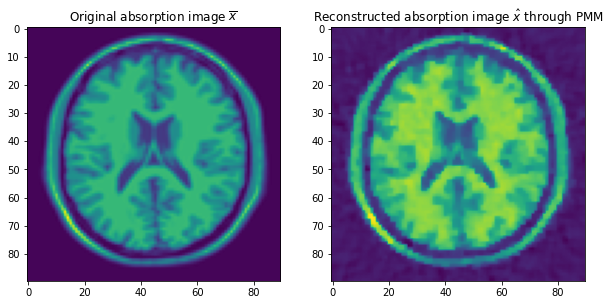

In [202]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].imshow(x.reshape((90,90), order = "F"))
ax[0].set_title("Original absorption image $\overline{x}$")
ax[1].imshow(x_hat_PMM.reshape((90,90), order = "F"))
ax[1].set_title("Reconstructed absorption image $\hat{x}$ through PMM") 
plt.show()

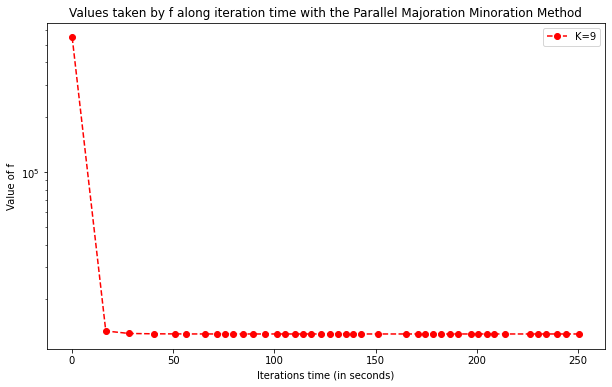

In [203]:
plt.figure(figsize=(10, 6))
plt.plot(iterations_PMM, f_liste_PMM, color='r', linestyle="--", marker="o", label=f"K={K_values[i]}")
plt.xlabel("Iterations time (in seconds)")
plt.ylabel("Value of f")
plt.yscale("log")
plt.title("Values taken by f along iteration time with the Parallel Majoration Minoration Method")
plt.legend()
plt.show()

3.6 Comparison of the methods 

1. Create a function that computes the value of the criterion $f$ along the iterations of the algorithm.

2. We will consider that the convergence is reached when the following stopping criterion is fulfilled : 

$$\Vert \nabla f(x_k) \Vert \le \sqrt(N)*10^{-4}$$

What is the required time for each method to achieve this condition ? For each method, plot the decrease of $(f(x_k))_{k \in \mathbb{N}}$ versus time until the stopping criterion is satisfied. 

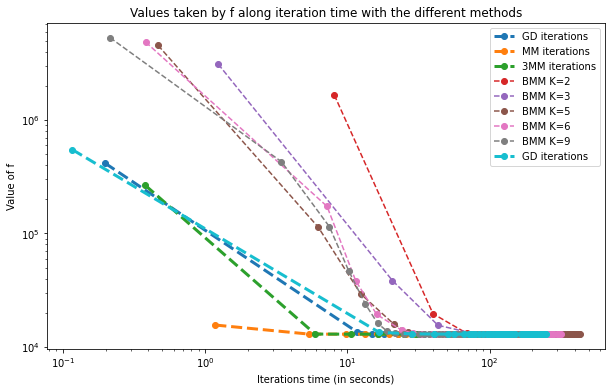

In [205]:
# Now that we have computed all the values of f for the different methods, we can compare them in a single plot in function of the time.
plt.figure(figsize=(10, 6))
colors = plt.get_cmap("tab10").colors
plt.plot(iterations_GD, f_liste_GD, color =colors[0%len(colors)], linestyle="--", marker="o", linewidth=3,  label= "GD iterations")
plt.plot(iterations_MM, f_liste_MM, color =colors[1%len(colors)], linestyle="--", marker="o", linewidth=3,  label= "MM iterations")
plt.plot(iterations_MMM, f_liste_MMM, color =colors[2%len(colors)], linestyle="--", marker="o", linewidth=3,  label= "3MM iterations")
for i in range(len(K_values)):
    plt.plot(iterations_BMM[i], f_liste_BMM[i], color=colors[(i+3)%len(colors)], linestyle="--", marker="o", label=f"BMM K={K_values[i]}")
plt.plot(iterations_PMM, f_liste_PMM, color =colors[9%len(colors)], linestyle="--", marker="o", linewidth=3,  label= "GD iterations")
plt.xlabel("Iterations time (in seconds)")
plt.ylabel("Value of f")
plt.xscale("log")
plt.yscale("log")
plt.title("Values taken by f along iteration time with the different methods")
plt.legend()
plt.show()

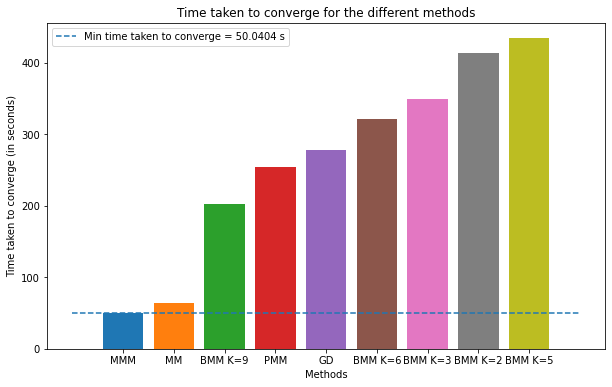

In [227]:
# Comparison of the different convergence times for the different methods
times = {'GD':final_time_GD, 'MM':final_time_MM, 'MMM':final_time_MMM, 'BMM K=2':final_time_BMM[0], 'BMM K=3':final_time_BMM[1], 'BMM K=5':final_time_BMM[2], 'BMM K=6':final_time_BMM[3], 'BMM K=9':final_time_BMM[4], 'PMM':final_time_PMM}
plt.figure(figsize=(10, 6))
colors = plt.get_cmap("tab10").colors
for i, (key, value) in enumerate(sorted(times.items(), key=lambda x: x[1])):
    plt.bar(key, value, color = colors[i%len(colors)])
plt.hlines(min(times.values()), -1, 9, color = colors[0], linestyle="--", label = f"Min time taken to converge = {min(times.values()):.{4}f} s")
plt.xlabel("Methods")
plt.ylabel("Time taken to converge (in seconds)")
plt.title("Time taken to converge for the different methods")
plt.legend()
plt.show()

3. The Signal to Noise Ratio (SNR) of a restored image $\hat{x}$ is defined as $$SNR = 10 log_{10}(\frac{\Vert \overline{x} \Vert^2}{\Vert \overline{x}-\hat{x} \Vert^2})$$
Using the fastest method, search for parameters $(\lambda, \delta)$ that optimize the SNR. 

The fastest method is : MMM as we can see with the above computed convergence times.

In [233]:
eps = 1e-8
def psi_CV(u, delta):
  return np.sqrt(1+ u**2/delta**2)

# Let's code this expression :
def psi_gradient_CV(u, delta):
    return u/(delta**2*psi_CV(u, delta))

def f_gradient_CV(x, Lambda, delta):
    gradient = H.T@(H@x-y) + Lambda*G.T@psi_gradient_CV(G@x, delta)
    return gradient
def f_CV(x, Lambda, delta):
    return 1/2*np.linalg.norm(H@x-y)**2+Lambda*np.sum(np.sqrt(1+(G@x)**2/delta**2))

In [234]:
# We compute SNR value : 
def SNR(x_hat):
    return 10*np.log10(np.linalg.norm(x)**2/np.linalg.norm(x-x_hat)**2)

In [235]:
def directions_subspace_CV(x_curr, Lambda, delta, x_previous=None, beginning = False):
    if beginning:
        return -f_gradient_CV(x_curr, Lambda, delta).reshape(-1,1)
    else:
        return np.column_stack((-f_gradient_CV(x_curr, Lambda, delta).reshape(-1, 1), (x_curr - x_previous).reshape(-1, 1)))

In [236]:
def u_vector_CV(x_curr, D_curr, Lambda, delta, beginning=False):
    D = D_curr
    vector = 1/(delta**2*np.sqrt(1+(G@x_curr)**2/delta**2))
    Diag = sparse.diags(vector).tocsc()
    first_term = H@D
    second_term = G@D
    comb = first_term.T@first_term + Lambda * second_term.T@Diag@second_term
    if beginning:
        third_term = D.T@f_gradient_CV(x_curr, Lambda, delta).reshape(-1,1)
    else:
        third_term = D.T@f_gradient_CV(x_curr, Lambda, delta)
    u = -linalg.pinv(comb)@third_term
    return u

In [253]:
def Maj_Min_Memory_Gradient_CV(f, f_gradient, Lambda, delta, x_tol):
    x_curr = x0.copy()
    f_liste = []
    iterations = []
    t0 = time.time()
    counter = 0
    D_0 = directions_subspace_CV(x_curr, Lambda, delta, beginning = True)
    u_0 = u_vector_CV(x_curr, D_0, Lambda, delta, beginning = True)
    x_next=x_curr+D_0@u_0.flatten()

    while np.linalg.norm(f_gradient_CV(x_next, Lambda, delta))>np.sqrt(N)*x_tol:
        x_previous = x_curr
        x_curr = x_next
        D_curr = directions_subspace_CV(x_curr, Lambda, delta, x_previous)
        u_curr = u_vector_CV(x_curr, D_curr, Lambda, delta)
        x_next = x_curr + D_curr@u_curr.flatten()
        if counter % 20 == 0:
            f_liste.append(f_CV(x_curr, Lambda, delta))
            iterations.append(time.time()-t0)
        counter += 1
    final_time = time.time()-t0
    return x_curr, f_liste, iterations, final_time

In [246]:
Lambda_values = np.linspace(0.01, 2, 5, endpoint = True)
delta_values = np.linspace(0.001, 2, 5, endpoint = True)
best_lambda = np.inf
best_delta = np.inf
SNR_max = -np.inf
for l in Lambda_values:
    for d in delta_values:
        x_hat_MMM_CV, f_liste_MMM_CV, iterations_MMM_CV, final_time_MMM_CV = Maj_Min_Memory_Gradient_CV(f_CV, f_gradient_CV, l, d, x_tol)
        print("Lambda =", l, "delta =", d, "SNR value :", SNR(x_hat_MMM_CV))
        if SNR(x_hat_MMM_CV) > SNR_max:    
            best_lambda = l
            best_delta = d
            SNR_max = SNR(x_hat_MMM_CV)
print("The best results are obtained for :")
print("- Best lambda :", best_lambda)
print("- Best delta :", best_delta)
print("and the best corresponding SNR value is :", SNR_max)

Lambda = 0.01 delta = 0.001 SNR value : 17.79383976833404
Lambda = 0.01 delta = 0.50075 SNR value : -5.444751291739839


KeyboardInterrupt: 

In [254]:
from joblib import Parallel, delayed
from itertools import product
Lambda_values = np.linspace(0.01, 0.5, 5, endpoint = True)
delta_values = np.linspace(0.001, 0.5, 5, endpoint = True)
param_grid = list(product(Lambda_values, delta_values))
def experiment(Lambda, delta, f_CV, f_gradient_CV, x_tol):
    x_hat_MMM_CV, f_liste_MMM_CV, iterations_MMM_CV, final_time_MMM_CV = Maj_Min_Memory_Gradient_CV(f_CV, f_gradient_CV, Lambda, delta, x_tol)
    return Lambda, delta, SNR(x_hat_MMM_CV), final_time_MMM_CV
results = Parallel(n_jobs=-1)(delayed(experiment)(l, d, f_CV, f_gradient_CV, x_tol) for l, d in param_grid)
best_params = max(results, key=lambda x:x[2])
print(f"Best parameters : lambda={best_params[0]}, delta={best_params[1]}, SNR={best_params[2]}, Time={best_params[3]}")

Best parameters : lambda=0.01, delta=0.001, SNR=17.79383976833404, Time=234.0669183731079


Those are the best values for lambda and delta in the linspace we spanned. It should have been more precise if we created a bigger linspace.